## Chiptune Geneation Project Sandbox

Notebook for trying out some code in an interactive, sandbox-like environment.

In [20]:
from modules import mcc_parser, mcc_waves
import matplotlib.pyplot as plt
%matplotlib inline

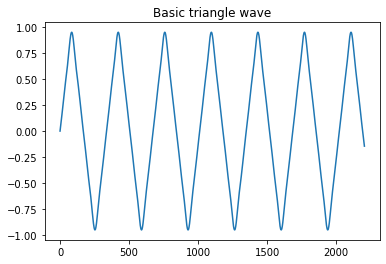

In [21]:
wave = mcc_waves.generate_triangle(48, 4, 0.05)
plt.plot(wave)
plt.title("Basic triangle wave")
plt.show()